# Exploratory data analysis

Introduction

Hypotheses to carry out
1. Choropleths to see distribution of amenity types?
2. Different distribution of amenities depending on population size (or density)?
3. Cluster stations based on amenities around?
4. Spatio-temporal cluster vs amenity cluster?
5. Regression analysis amenity cluster vs traffic at a certain time?

We used the following data sets
1. London Datastore (London shape files);
2. Office for National Statistics (London population);
3. Transport for London (metro traffic);
4. Wikimedia Commons (metro station locations);
5. OpenStreetMaps (points of interest).

Methods that we're planning to use
1. Hierarchical clustering?

Notebook overview

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from create_hexgrid import create_hexgrid
from tobler.area_weighted import *
import tobler
plt.style.use('seaborn')

In [3]:
population = gpd.read_file('data/processed/population/boroughs.json')
# Keep only the columns of interest
population = population[['LAD11NM', 'total_population', 'adult_population', 'geometry']]

# Change index to make merge easier
population.set_index('LAD11NM', inplace=True)

pois = pd.read_csv('data/processed/pois/poi_counts.csv')
# Change index to make merge easier
pois.set_index('pois_category', inplace=True)

# Let's combine these two
df = pd.concat([pois, population.T])

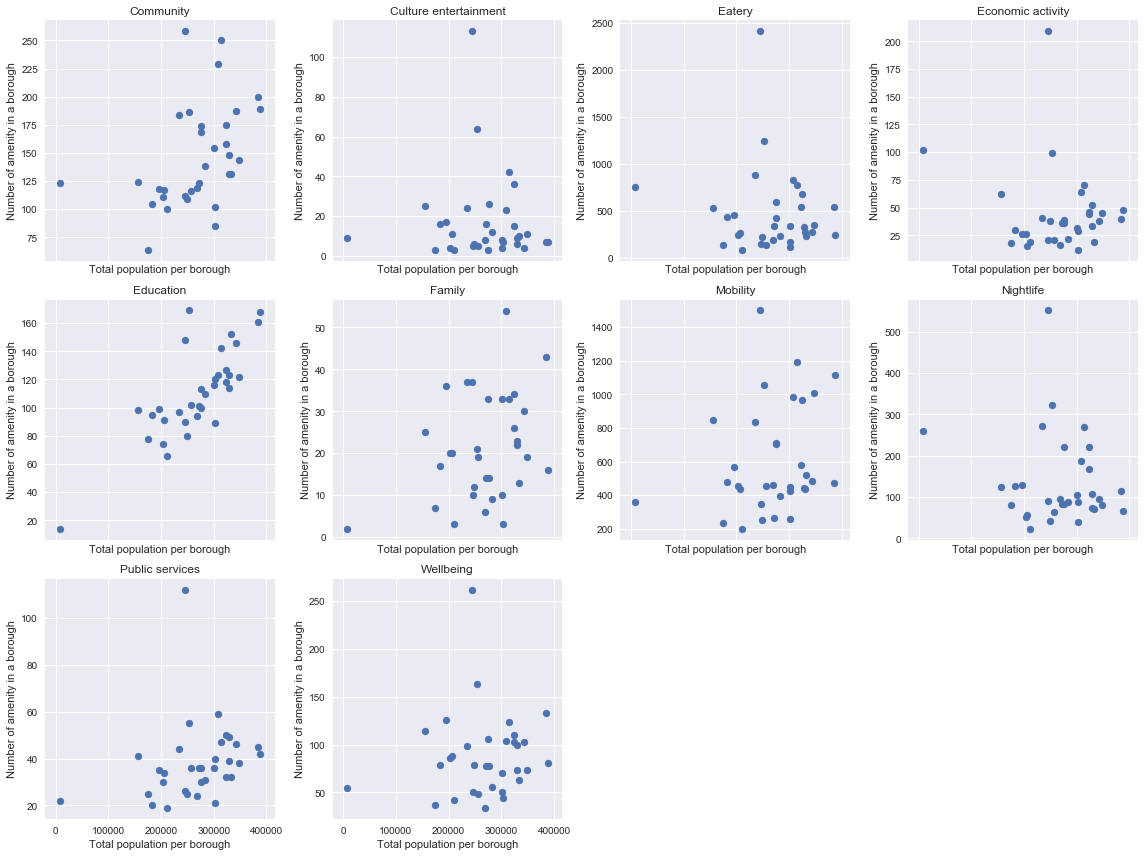

In [123]:
nrows = 3
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,12), sharex=True)
k = 0
index = df.index.tolist()

for i in range(nrows):
    for j in range(ncols):
        ax[i, j].scatter(df.loc["total_population"], df.iloc[k])
        ax[i, j].set_title(df.index[k])
        ax[i, j].set_xlabel('total_population')
        ax[i, j].set_title(f'{df.index[k].capitalize().replace("_", " ")}')
        ax[i, j].set_ylabel(f'Number of amenity in a borough')
        # ax[i, j].set_ylabel(f'Number of amenity in a borough (log)')
        ax[i, j].set_xlabel('Total population per borough')
        # ax[i, j].set_yscale('log')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[2, 2])
fig.delaxes(ax[2, 3])
fig.tight_layout()
plt.show()

In [4]:
gdf = gpd.GeoDataFrame(df.T, geometry='geometry')
gdf.crs = population.crs
gdf.to_crs(epsg=3857, inplace=True)

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
gdf.iloc[:,:-3] = gdf.iloc[:,:-3].apply(pd.to_numeric)

In [76]:
hexgrid = create_hexgrid(gdf.reset_index(drop=True)[['geometry']].to_crs(epsg=4326), hex_res=8, buffer=0.002, plot=False)
hexgrid.reset_index(drop=True, inplace=True)
hexgrid.crs = gdf.to_crs(epsg=4326).crs
# hexgrid = tobler.area_weighted.area_interpolate(gdf.reset_index(drop=True).to_crs(epsg=4326), hexgrid, extensive_variables=columns.tolist(), allocate_total=True)
# hexgrid.crs = gdf.to_crs(epsg=4326).crs

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [77]:
pois = pd.read_csv('data/raw/pois/pois.csv')
pois = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois['lon'], pois['lat']))
pois['geometry'] = pois['geometry'].apply(lambda x:x.centroid)
pois.crs = {'init':'epsg:4326'}

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (10,22,27,29,30,31,32,33,34,35,36,37,38,39,40,42,43,47,48,49,52,53,55,56,57,58,59,60,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,87,88,90,91,92,93,94,97,98,99,100,101,102,103,104,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
# Load categories and merge them with POIs data
pois_categories = pd.read_csv("data/external/pois_categories.csv")
pois = pd.merge(pois, pois_categories, left_on='amenity', right_on="pois")
pois.drop('amenity', axis=1, inplace=True)

In [79]:
# Remove amenities tagged 'misc'
pois = pois[pois['pois_category'] != "misc"]

# Drop duplicated amenities
# pois = pois.drop_duplicates(subset=["geometry", "name", "pois"]).reset_index(drop=True)

In [80]:
sjoin_pois = gpd.sjoin(pois, hexgrid)
sjoin_pois

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,Unnamed: 0,tags,changeset,id,timestamp,lon,lat,version,addr:city,addr:country,...,doityourself,lottery,ticket,tobacco,water,poi_type,pois,pois_category,index_right,hex_id_8
0,0,"{""contact:phone"":""+44 20 73771843"",""contact:we...",0.0,108042,1573153278,-0.135513,51.523560,22,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,pub,pub,nightlife,644,88195da4d7fffff
174,858,"{""created_by"":""Merkaartor 0.12""}",0.0,49319602,1325546064,-0.133772,51.521820,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,pub,pub,nightlife,644,88195da4d7fffff
392,2110,"{""fhrs:id"":""426441"",""source:addr"":""FHRS Open D...",0.0,257937397,1436081111,-0.138689,51.523186,7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,pub,pub,nightlife,644,88195da4d7fffff
643,4707,"{""toilets"":""yes"",""toilets:access"":""customers""}",0.0,294599679,1551546221,-0.137852,51.525906,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,pub,pub,nightlife,644,88195da4d7fffff
767,5703,"{""fhrs:confidence_management"":""0"",""fhrs:hygien...",0.0,312159181,1543944275,-0.143984,51.523320,9,London,NaN,...,NaN,NaN,NaN,NaN,NaN,pub,pub,nightlife,644,88195da4d7fffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80407,27663,"{""sport"":""swimming"",""covered"":""yes""}",0.0,2270065339,1366150864,0.068835,51.368507,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,swimming_pool,swimming_pool,wellbeing,394,88194ad73bfffff
80625,72382,"{""access"":""yes"",""capacity"":""3"",""fee"":""yes"",""pa...",0.0,7237210927,1582479787,-0.089499,51.320606,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,charging_station,charging_station,mobility,756,88194ac053fffff
80739,28097,NaN,0.0,2312646589,1419663752,0.072356,51.501140,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,estate_agent,estate_agent,economic_activity,2041,88194e6d61fffff
80750,29620,NaN,0.0,2431488347,1377461396,-0.087506,51.619812,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,bbq,bbq,eatery,934,88195da65bfffff


In [81]:
entry = gpd.read_file('../spacetimegeo/data/processed/counts/entry_station.json')

In [82]:
entry.crs

{'init': 'epsg:4326'}

In [83]:
sjoin_entry = gpd.sjoin(entry[['total', 'geometry']], hexgrid)

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


<Figure size 576x396 with 0 Axes>

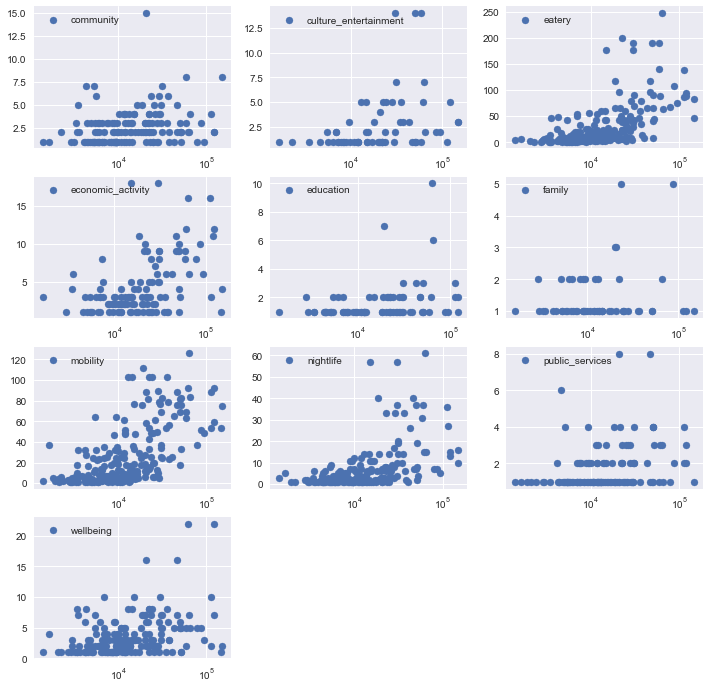

In [101]:
fig = plt.figure()
nrows = 4
ncols = 3
plt.figure(figsize=(12,12))
plot_num = 1
labels = {}
d = {}

for i in range(10):
    data = pd.merge(groupby.loc[columns[i]], hexgrid, left_on=groupby.loc[columns[i]].index, right_on='hex_id_8')
    data = pd.merge(data, sjoin_entry, left_on='hex_id_8', right_on='hex_id_8')
    plt.subplot(nrows, ncols, plot_num)
    plt.scatter(data['total'], data['n'], label=columns[i])
    plt.legend()
    # plt.yscale('log')
    plt.xscale('log')
    plot_num += 1

fig.legend(columns)

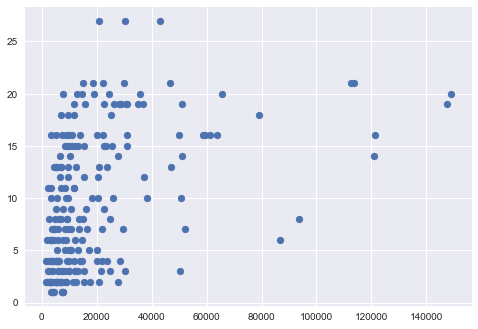

In [91]:
sjoin_pois['n'] = 1

In [92]:
groupby = sjoin_pois.groupby(['pois_category', 'hex_id_8']).sum()

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is depr

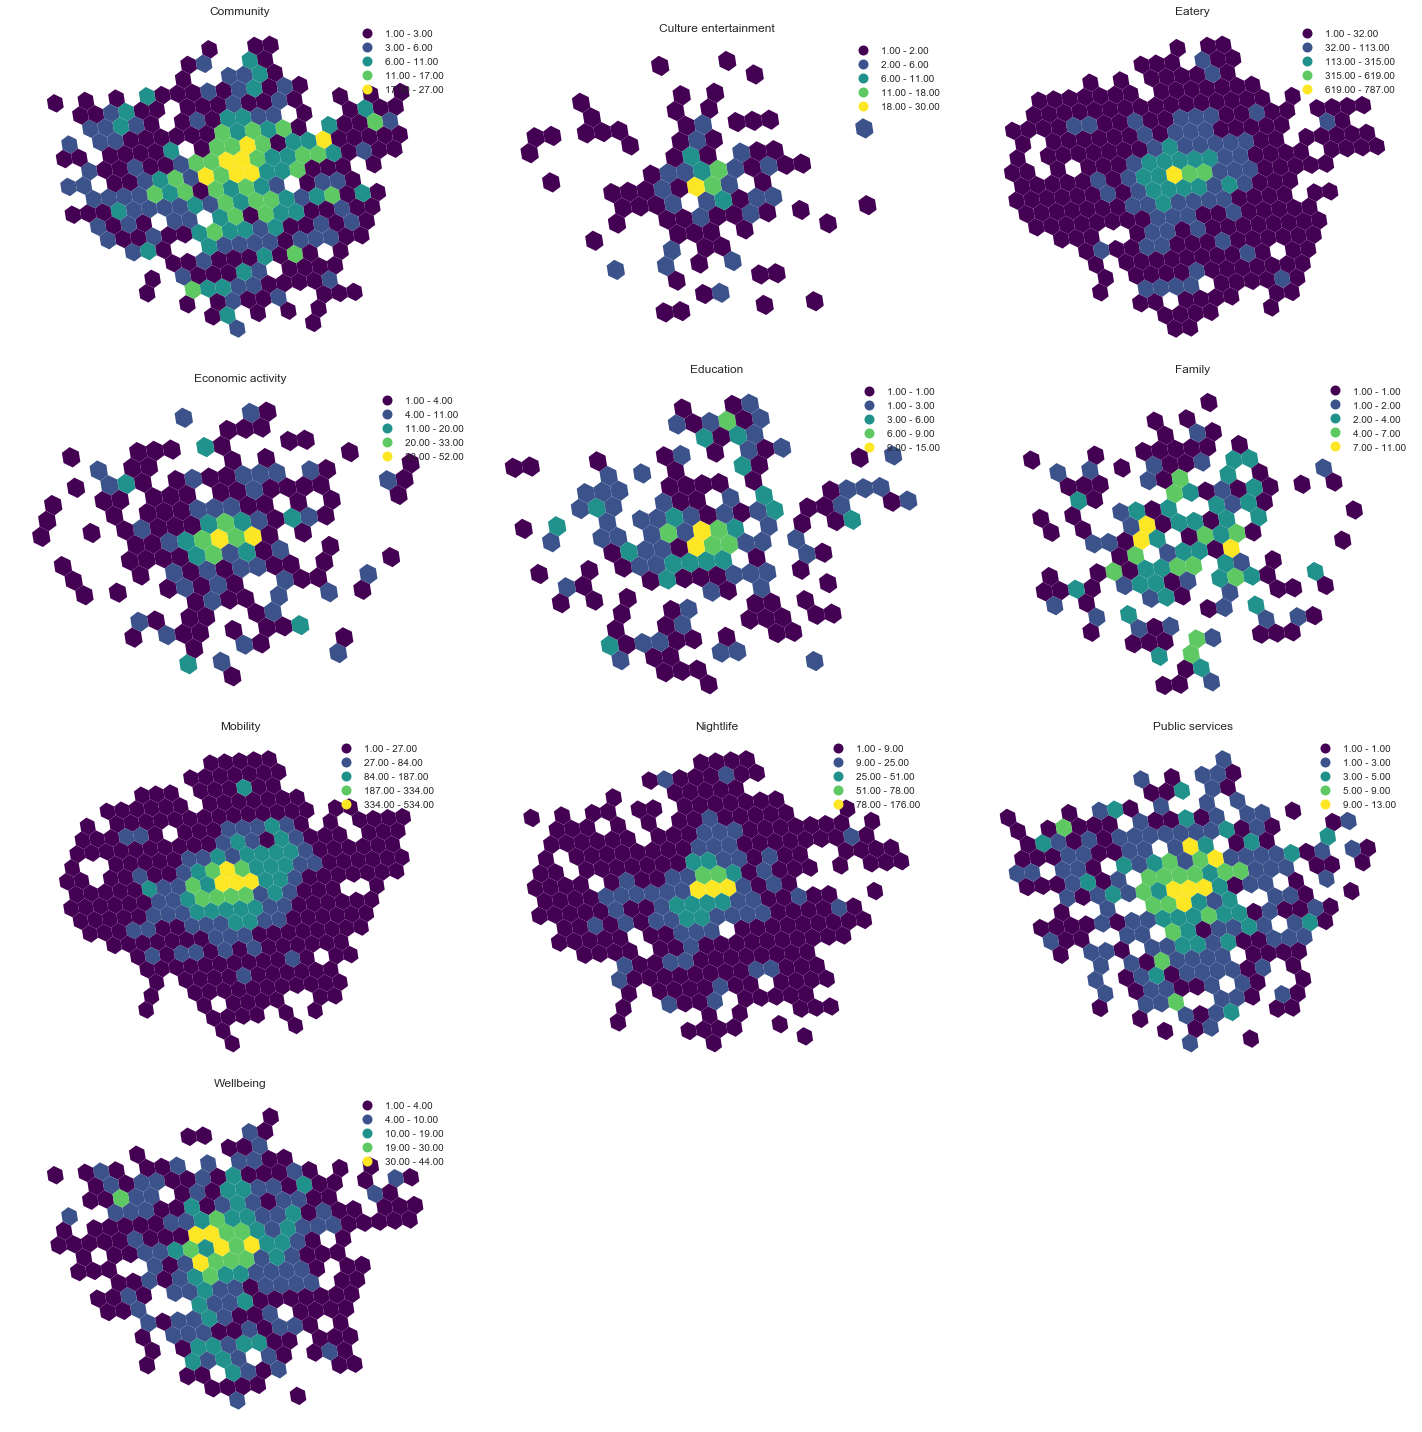

In [14]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
k = 0
columns = gdf.columns[:-3]
for i in range(nrows):
    for j in range(ncols):
        merge = pd.merge(groupby.loc[columns[k]], hexgrid, left_on=groupby.loc[columns[k]].index, right_on='hex_id_7')
        merge = gpd.GeoDataFrame(merge, geometry='geometry')
        merge.crs = {'init':'epsg:4326'}
        merge.to_crs(epsg=3857).plot(column='n', ax=ax[i, j], legend=True, scheme='fisher_jenks', cmap='viridis')
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].axis('off')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()

In [ ]:
for column in columns:a
    

In [12]:
# Get total counts of POIs types in each borough
# Boroughs are tagged LAD11NM
pois_counts = pois.groupby(['pois_category', 'LAD11NM']).agg(len)
pois_counts = pois_counts.reset_index()
pois_counts = pois_counts.pivot(index="pois_category", columns ="LAD11NM", values= "name")

In [298]:

merge.crs 

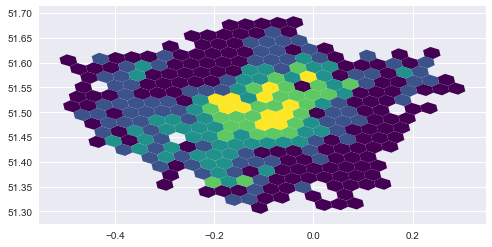

In [299]:
merge.plot(column='index_right', scheme='fisher_jenks', cmap='viridis')

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is depr

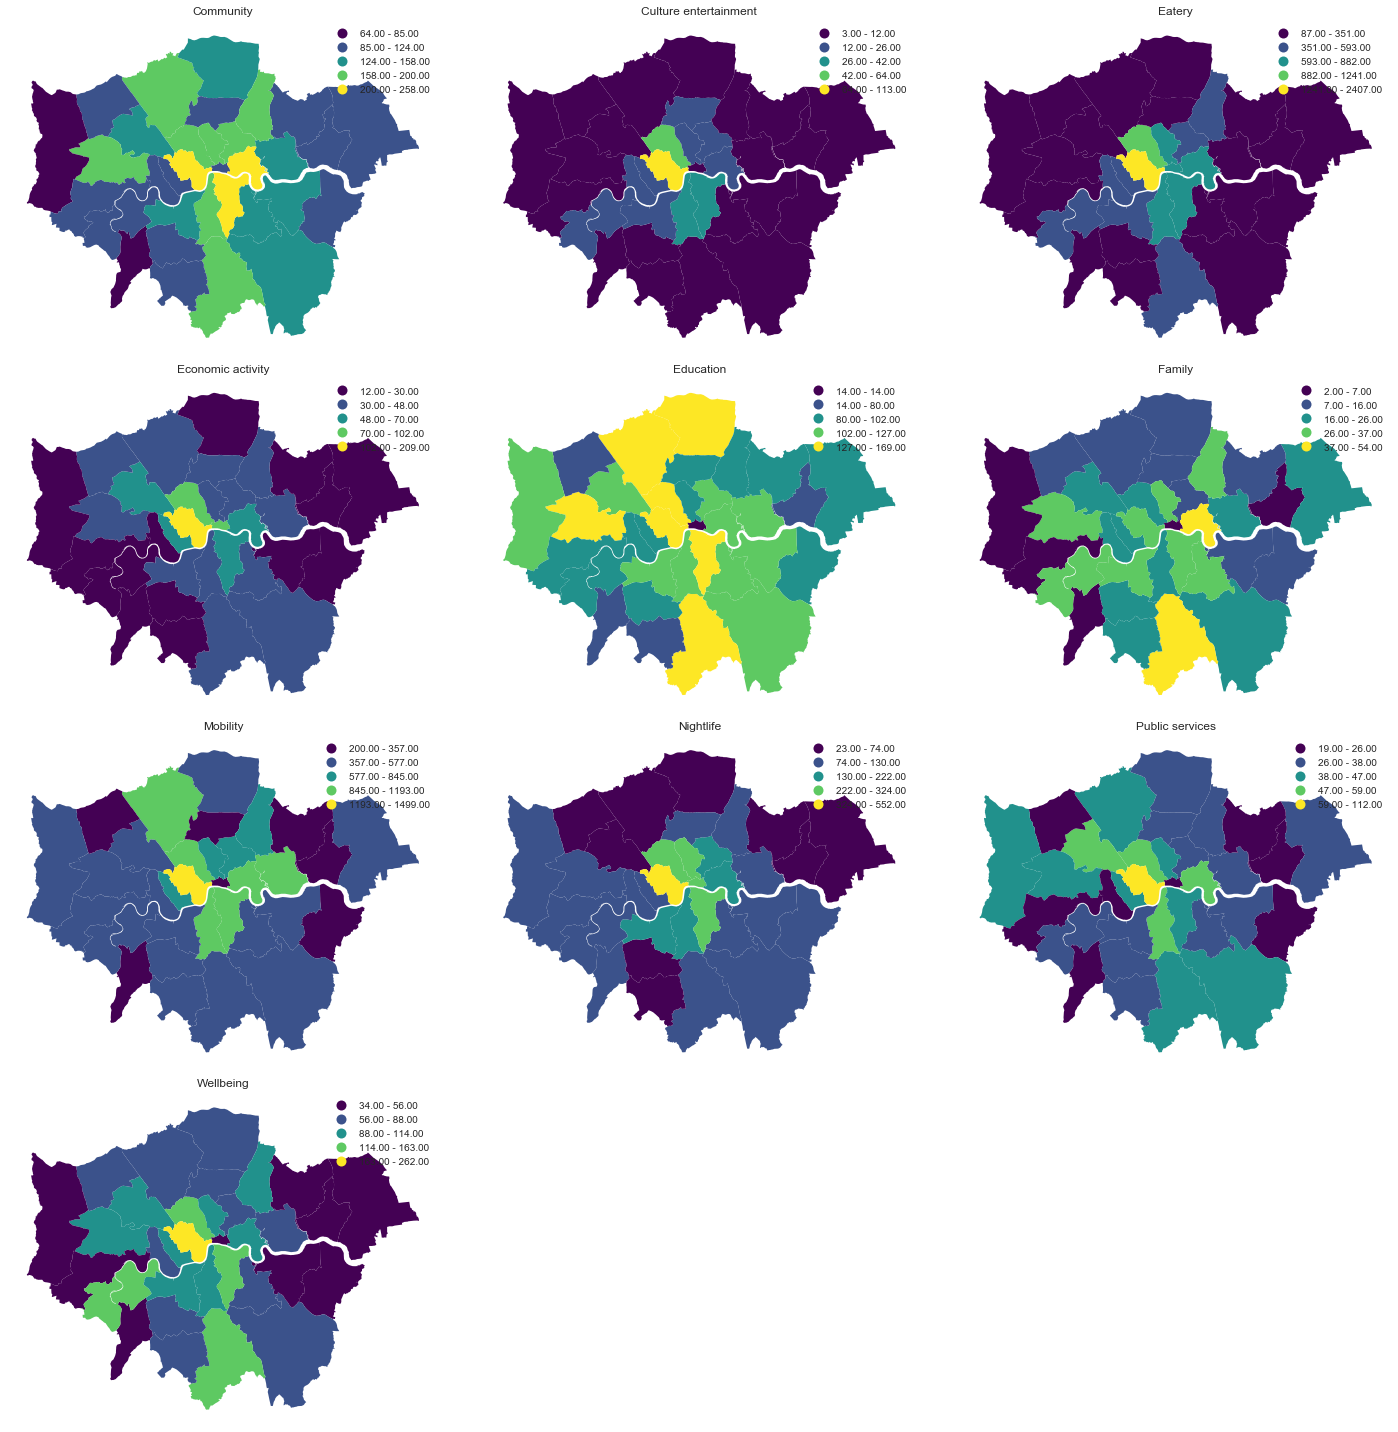

In [233]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
k = 0
columns = gdf.columns[:-3]
for i in range(nrows):
    for j in range(ncols):
        gdf.to_crs(epsg=3857).plot(column=columns[k], ax=ax[i, j], legend=True, scheme='fisher_jenks', cmap='viridis')
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].axis('off')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()

# Analyzing stations data

In [38]:
stn_points = []
stations.to_crs(epsg=4326, inplace=True) # CRS should be EPSG=4326 when grabbing data from OSM
for geometry in stations["geometry"]:
    x, y = geometry.xy
    x = x[0]
    y = y[0]
    stn_points.append((y, x))
stations["stn_points"] = stn_points

#### Defining voronoi's around stations

In [39]:
# Convert all CRS's to EPSG=27700
amenities.to_crs(epsg=27700, inplace=True)
london.to_crs(epsg=27700, inplace=True)
boroughs.to_crs(epsg=27700, inplace=True)
stations.to_crs(epsg=27700, inplace=True)

In [40]:
# stations are epsg=27700

# Define Voronoi
x = stations.geometry.x
y = stations.geometry.y
coords = list(zip(x, y))
voronoi = spatial.Voronoi(coords)

# Convert Voronoi cells to Shapely polygons
stations["cell"] = None
for i, idx_region in enumerate(voronoi.point_region):
    region = voronoi.regions[idx_region]
    cell_coords = [Point(voronoi.vertices[idx_point]) for idx_point in region]
    cell = Polygon([[p.x, p.y] for p in cell_coords])
    stations.loc[i, "cell"] = cell

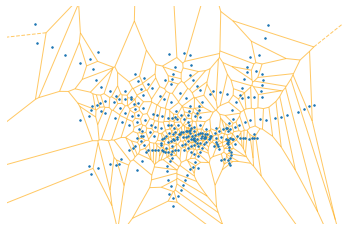

In [41]:
spatial.voronoi_plot_2d(voronoi, show_vertices=False, line_colors='orange',
                line_width=1, line_alpha=0.6, point_size=3)
plt.axis("off")

plt.show()

In [42]:
london_bbox = london.total_bounds
london_bbox = box(london_bbox[0], london_bbox[1], london_bbox[2], london_bbox[3])
station_vor = stations.set_geometry("cell").loc[stations.set_geometry("cell").within(london_bbox)] # set GDF geometry to be voronoi geometry

#### Matching amenities data with station data

In [43]:
# match amenities to voronoi cells
amenities_voronois = gpd.sjoin(amenities[["name", "amenity", "LAD11NM", "geometry", "amenity_category"]],
                               station_vor[["station_name", "geometry", "cell"]], how="inner")

In [44]:
# get number of amenities for each amenity category
amenities_grouped = pd.DataFrame(amenities_voronois.groupby(["station_name", "amenity_category"]).agg(len)["amenity"])

In [45]:
# transform the data into more easily operationalizable format
records = pd.DataFrame(amenities_grouped.to_records())

In [46]:
amenity_categories = records['amenity_category'].unique()
print(amenity_categories.shape)

station_names = records['station_name'].unique()
print(station_names.shape)

(10,)
(276,)


In [47]:
# Generate new dataframe
columns = amenity_categories
index = station_names
data = pd.DataFrame(index=index, columns=columns)

In [48]:
# Fill the new dataframe
for index, row in data.iterrows():
    s = records[records['station_name'] == index][['amenity_category', 'amenity']]
    s.set_index('amenity_category', inplace=True)
    for i, r in s.iterrows():
        data.loc[index, i] = r['amenity']
data.fillna(0, inplace=True)

In [49]:
# # Combine station clusters with amenities and total counts
entry_station_cluster = entry_station_cluster[['station_name', 'total', 'label']]
entry_station_cluster.rename({'total' : 'total_counts'}, axis=1, inplace=True)

In [50]:
result = pd.merge(data, entry_station_cluster, left_on=data.index, right_on='station_name')

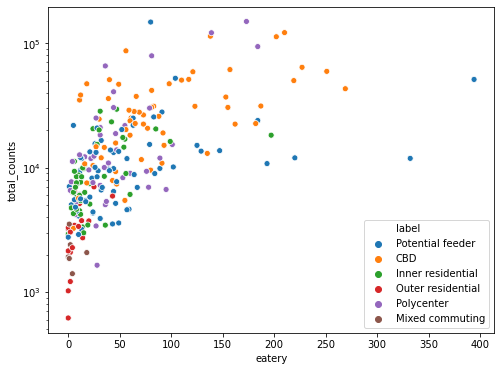

In [51]:
# take a look at amenity frequency based on station cluster label
plt.figure(figsize=(8,6))
sns.scatterplot(x="eatery", y="total_counts", hue="label", data=result)
plt.yscale('log')

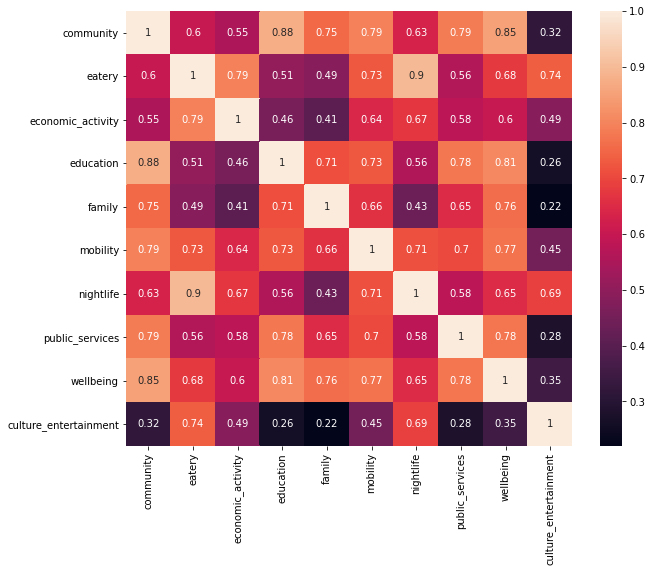

In [52]:
# relationships between amenity types?
plt.figure(figsize=(10,8))
sns.heatmap(result.iloc[:,:-3].corr(), annot=True)

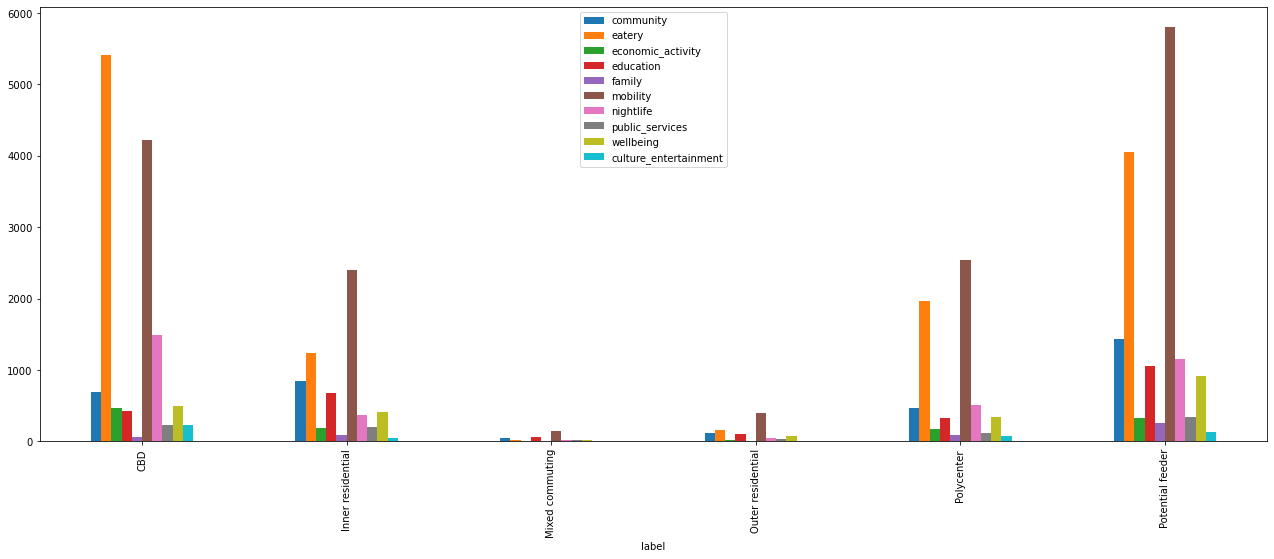

In [53]:
result.groupby('label').sum().iloc[:,:-1].plot.bar(figsize=(22,8))

In [54]:
data_i = data.reset_index()
X = data_i.iloc[:,1:]
y = data_i.iloc[:, 0]

In [55]:
# Get amenity compositions for each station
# Number of each amenity type as a fraction of total amenities within a station voronoi
X["total"] = X.sum(axis=1)
X_frac = X.iloc[:,:-1].div(X.total, axis=0)

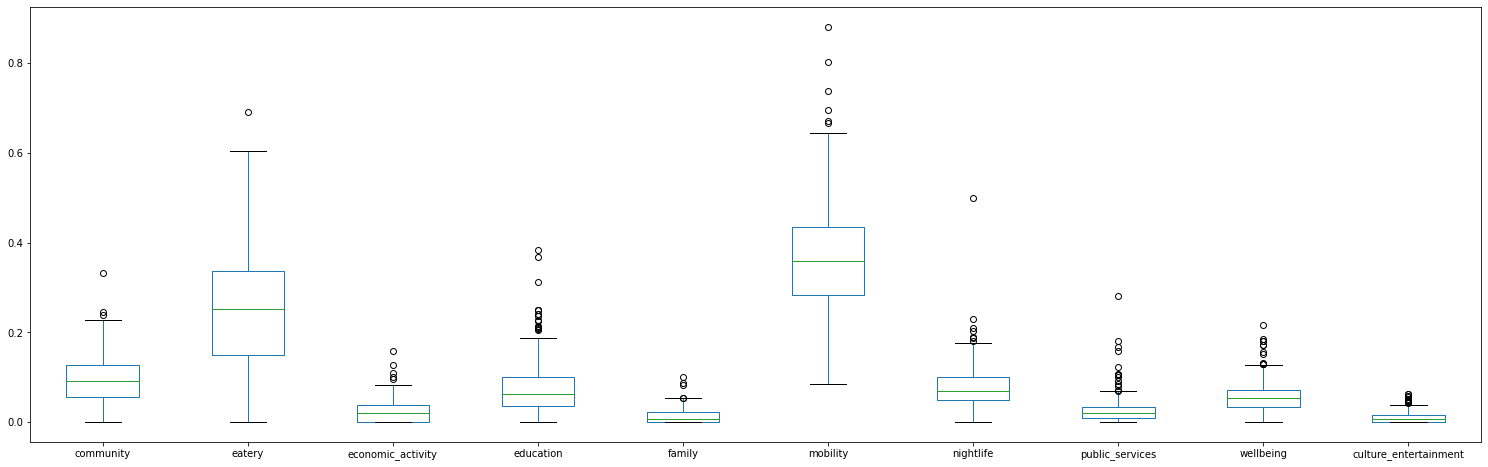

In [56]:
X_frac.plot.box(figsize=(26,8))

#### Clustering stations based on amenity composition

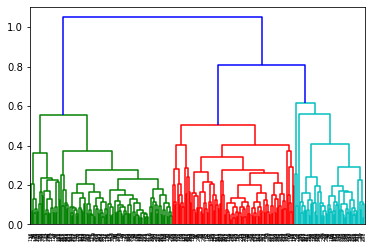

In [57]:
# dendrogram to get an idea of how many clusters
dend = shc.dendrogram(shc.linkage(X_frac, method='complete')) # "complete" for more compact clusters?

In [58]:
# define number of clusters and get labels
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
label = cluster.fit_predict(X_frac)

In [59]:
data['amenity_cluster'] = label

In [60]:
df = pd.merge(data, stations[['station_name', 'geometry']], left_on=data.index, right_on=stations['station_name'])

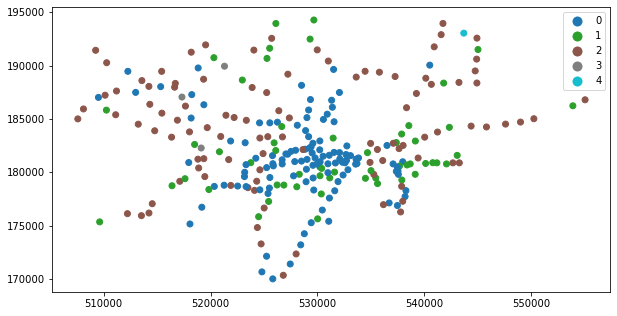

In [61]:
# review station types as categorized by amenity composition
gpd.GeoDataFrame(df, geometry=df['geometry']).plot(column='amenity_cluster', categorical=True, legend=True, figsize=(10,6))

#### Comparing stations - cluster labels from travel patterns + cluster labels from amenity composition

In [62]:
data.reset_index(inplace=True)
data.rename(columns={"index":"station_name"}, inplace=True)

In [63]:
data = data.merge(entry_station_cluster[["station_name", "label"]], on="station_name")

In [64]:
data = data.merge(stations[["station_name", "stn_points"]], on="station_name")

In [65]:
data.groupby(["label", "amenity_cluster"]).agg({"station_name":"count"}).reset_index().sort_values(["label", "station_name"], ascending=False)

,label,amenity_cluster,station_name
16,Potential feeder,0,29
18,Potential feeder,2,27
17,Potential feeder,1,12
19,Potential feeder,3,1
13,Polycenter,0,22
14,Polycenter,1,10
15,Polycenter,2,10
11,Outer residential,2,12
10,Outer residential,1,3
9,Outer residential,0,2


In [66]:
data["lat"] = [x[0] for x in data["stn_points"]]
data["lon"] = [x[1] for x in data["stn_points"]]

In [67]:
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat))

In [68]:
# fig = px.scatter_mapbox(data, lat="lat", lon="lon", color="amenity_cluster", 
#                   hover_name = data.station_name, hover_data = data[["label", "amenity_cluster"]],
#                   zoom=9, mapbox_style="carto-positron")

# fig.show()

In [69]:
data.crs = {'init': 'epsg:4326'} # station date file is epsg=4326
data.to_crs(epsg=27700, inplace=True)

C:\Users\jryap\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



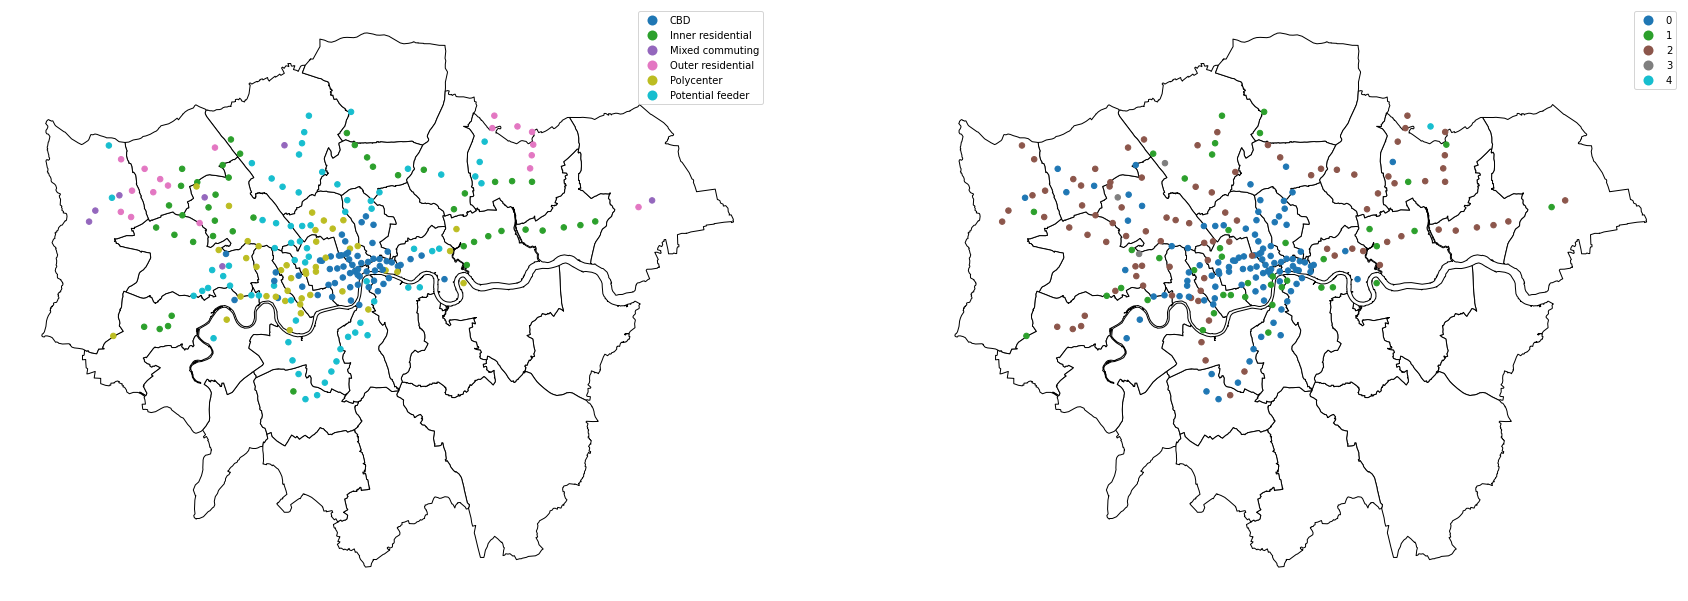

In [70]:
fig, ax = plt.subplots(figsize=(30,15), ncols=2) 

boroughs.plot(ax=ax[0],color='white', edgecolor='black')
boroughs.plot(ax=ax[1],color='white', edgecolor='black')

data.plot(ax=ax[0], column='label', categorical=True, legend=True, legend_kwds = {'bbox_to_anchor': (1, 1)},
                markersize=30)
data.plot(ax=ax[1], column='amenity_cluster', categorical=True, legend=True, legend_kwds = {'bbox_to_anchor': (1, 1)},
                markersize=30)
ax[0].axis('off')
ax[1].axis('off')

plt.show()
# plt.savefig('map.png')

#### ~Messing around

In [71]:
data["label_c"] = data.apply(lambda x : "CBD" if (x.label == "CBD") else ("Potential feeder" if (x.label=="Potential feeder") else ("Polycenter" if (x.label == "Polycenter") else ("Inner Resi" if (x.label == "Inner residential") else "Other"))), axis=1)

(500655.0638336639, 564875.8138502047, 153596.65686413186, 203187.7489867522)

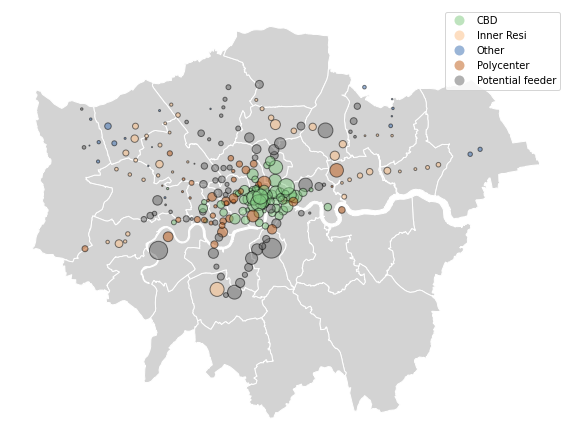

In [73]:
cat_of_interest = "eatery"

ax = boroughs.plot(color='lightgrey', edgecolor='white', figsize=(10,18))

data.plot(ax=ax, markersize=cat_of_interest, column=data['label_c'], cmap= "Accent", 
              edgecolor="black", alpha=.5, legend=True, legend_kwds = {'bbox_to_anchor': (1, 1)})

ax.axis('off')

## Conclusion